# Sensor failure Detection and prediction


## Initialize Imports and mount the dataset

In [1]:
# !git clone https://github.com/bigdog3626/SensorFailurePrediction.git

fatal: destination path 'SensorFailurePrediction' already exists and is not an empty directory.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import datetime
DataSet = 'sensor-fault-detection.csv'
# DataSet = '/content/SensorFailurePrediction/sensor-fault-detection.csv'

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

## Create Helper Functions

### Plot Per Columns Distribution

In [3]:
def plotPerColumnsDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize=(6*nGraphPerRow, 8*nGraphRow), dpi = 80, facecolor= 'w', edgecolor='k')
    
    for i in range(min(nCol, nGraphShown)) :
        plt.subplot(nGraphRow, nGraphPerRow, i+1)
        columnDF = df.iloc[:,i]
        if (not np.issubdtype(type(columnDF.iloc[0]),np.number)):
            valueCounts = columnDF.value_counts()
            valueCounts.plot.bar()
            
        else:
            columnDF.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 
    plt.show()

### Plot Correlation Matrix

In [4]:
def plotCorrelationMatrix(df, graphWidth):
    fileName = df.dataframeName
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    
    if df.shape[1] < 2:
        print(f'No Correlation plots to show\n num of Nan or constant columns({df.shape[1]}) is less than 2') 
        return
    corr = df.corr()
    plt.figure(num=None, figsize = (graphWidth, graphWidth),  dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {fileName}', fontsize= 15)
    plt.show()     

### Plot Scatter Matrix

In [5]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
 

## Create Dataframe


In [6]:


df = pd.read_csv(DataSet, sep=';', parse_dates=[1])
df.dataframename = 'sensor-fault-detection.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 62629 rows and 3 columns


Inspect our data

In [7]:
df.head(5)

,Timestamp,SensorId,Value
0,2017-03-01T23:20:00+03:00,1,18.479807
1,2017-03-02T04:00:00+03:00,1,19.539112
2,2017-03-23T06:25:00+03:00,1,19.250198
3,2017-03-23T19:35:00+03:00,1,18.961285
4,2017-04-04T15:10:00+03:00,1,25.321623


Get some statistics about our data

Convert timetamps to float of YYYYMMDD.HHMMSS

In [8]:
def datToFloat(x):

  x = x.str.replace('-', '')
  x = x.str.replace('T', '')
  x = x.str.replace(':', '')
  x = x.str.replace('+', '')
  x = x.str[:8] + '.' + x.str[8:14]
  
  return x
  



df['ConvertedTimeStamp'] = datToFloat(df.Timestamp)

df.sort_values(by=['ConvertedTimeStamp'], inplace=True)

df.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,Timestamp,SensorId,Value,ConvertedTimeStamp
52785,2016-08-01T01:00:00+03:00,1,27.636770,20160801.010000
42926,2016-08-01T02:00:00+03:00,1,27.250818,20160801.020000
4117,2016-08-01T03:00:00+03:00,1,27.154348,20160801.030000
1566,2016-08-01T04:00:00+03:00,1,26.768456,20160801.040000
17915,2016-08-01T08:00:00+03:00,1,25.418072,20160801.080000


## Begin pre-processing the Data.

In [9]:
df.describe()

,Value
count,62629.000000
mean,24.203861
std,5.411599
min,6.886155
25%,21.369419
50%,24.550188
75%,27.443794
max,149.601822


Check missing values for each column

In [10]:
df.isnull().sum(axis=1)
df.isnull().sum(axis=0)

Timestamp             0
SensorId              0
Value                 0
ConvertedTimeStamp    0
dtype: int64

Check for outliers via boxplot

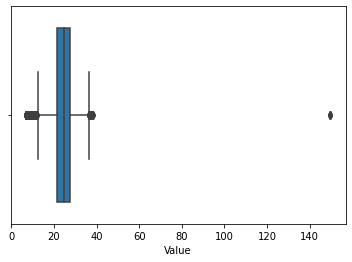

In [11]:
sns.boxplot(x=df['Value'])

Create a scatter plot to understand scale of outliers

In [12]:
x = df['ConvertedTimeStamp']
y = df['Value']

plt.scatter(x,y, alpha=0.5)
plt.show()

KeyboardInterrupt: ignored

Replace empty values as NULL

In [ ]:
df.replace(r'^\s*$', np.nan, regex = True)

## Begin Generating Graphs

In [ ]:
sns.histplot(df, x='Value', binwidth=5)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['Value'], ['ConvertedTimeStamp']])

centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]

## add to df
df['cen_x'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
df['cen_y'] = df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
df['c'] = df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})